**Indiquer dans la boîte ci-dessous vos noms et prénoms**

Abdelraouf KESKES

# 3I026 - Intelligence artificielle & Data science

## TP 2 - k-plus proches voisins (*k-NN*)

Dans ce TP, nous allons principalement mettre en place une "architecture" de code nous permettant petit à petit de tester différents modèles d'apprentissage supervisé et programmer les k-NN. Nous allons nous restreindre au cas binaire où les données sont étiquetées $+1$ ou $-1$.

In [6]:
import numpy as np
import pandas as pd

**Remarque** La concaténation de vecteurs s'obtient à l'aide de la fonction `vstack` de numpy.

### Étape 1: dataset

La première étape consiste à définir une classe permettant de stocker les données d'apprentissage, de validation et de test. Nous considérerons que les données tiennent en mémoire. Nous allons définir une classe permettant de stocker des couples $\{(x_1,y_1),...,(x_n,y_n)\}$. Les $x_i$ et $y_i$ seront des tableaux numpy.

In [7]:
class LabeledSet:  
    
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self,vector,label):
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x, vector))
            self.y = np.vstack((self.y, label))
        
        self.nb_examples = self.nb_examples + 1
    
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
    
    #Renvoie le nombre d'exemples dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self, i):
        return self.x[i]
        
    
    #Renvouie la valeur de y_i
    def getY(self, i):
        return(self.y[i])

#### Génération de données ''Jouet''

Nous allons pour l'instant nous intéresser à des datasets "jouet" générés selon des distributions choisies à la main. Commençons par un dataset en 2 dimensions (entrée) et 1 dimension (sortie): $x_i \in \mathbb{R}^2$, $y_i \in \{-1;+1\}$ tel que les données sont générées selon deux gaussiennes. Pour cela, nous utiliserons la fonction `numpy.random.multivariate_normal` - http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html

- `positive_center` est le centre de la gaussienne des points positifs (vecteur de taille 2)
- `positive_sigma` est la variance de la gaussienne (sous forme de matrice 2*2)
- Idem pour `negative`

Générer une premiere gaussienne associée au label $+1$.

Y ajouter une seconde gaussienne associée au label $-1$.

In [8]:
import matplotlib.pyplot as plt

#Positive
positive_center = [20, 20]
positive_sigma = [[10, 0], [0, 50]]
x, y = np.random.multivariate_normal(positive_center, positive_sigma, 150).T
ls= LabeledSet(2)
for i in range(len(x)):
    ls.addExample((x[i],y[i]),1)
#Negative
negative_center = [-20, -20]
negative_sigma = [[10, 0], [0, 50]]
x, y = np.random.multivariate_normal(negative_center, negative_sigma, 150).T
for i in range(len(x)):
    ls.addExample((x[i],y[i]),-1)


Le data set peut être affiché en utilisant matplotlib (pour vérifier) et plus précisément la fonction `matplotlib.pyplot.scatter` permettant de dessiner un nuage de points - http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter -

In [9]:
import matplotlib.pyplot as plt
# Permet d'afficher les figures directement dans le notebook:
%matplotlib inline

def plot2DSet(dataset):
    plt.scatter(dataset.x[0:int(dataset.size()/2),0],dataset.x[0:int(dataset.size()/2),1],marker='o')
    plt.scatter(dataset.x[int(dataset.size()/2):dataset.size(),0],dataset.x[int(dataset.size()/2):dataset.size(),1],marker='x')

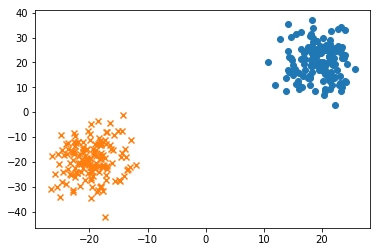

In [10]:
plot2DSet(ls)

### Étape 2: les classifieurs

Un classifieur (binaire) permet, pour chaque point d'entrée, de calculer un score. Si le score est négatif, la donnée est associée à la classe $-1$, sinon à la classe $+1$. Commençons par définir une classe permettant par la suite de définir plusieurs classifieurs.

Pour l'instant les méthodes `train` et `predict` ne seront pas définies car elles dépendent du modèle.

La fonction `computeAccuracy` renvoie le pourcentage de points bien classés. Elle peut être définie dès maintenant.



In [11]:
class Classifier:
    def __init__(self, input_dimension):
        raise NotImplementedError("Please Implement this method")
    
    
    #Permet de calculer la prediction sur x => renvoie un score
    def predict(self, x):
        raise NotImplementedError("Please Implement this method")

    
    #Permet d'entrainer le modele sur un ensemble de données
    def train(self, labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    #Permet de calculer la qualité du système 
    def accuracy(self, dataset):
        S = 0
        n = dataset.size()  
        for i in range(n):
            if ( self.predict (dataset.getX(i)) * dataset.getY(i) > 0 ) : 
                S += 1
        return (S*100.00/n )

Nous allons maintenant définir un classifieur linéaire aléatoire :
- la fonction `predict` renvoie la valeur de $\langle x | w\rangle$ où $w$ est un vecteur (de taille `input_dimension`) tiré aléatoirement à la construction du classifieur.


In [12]:
class ClassifierRandom(Classifier):
    
    def __init__(self, input_dimension):
        self.input_dimension=input_dimension
        self.w=np.random.randn(input_dimension)
        
    def predict (self,x) :
        return (np.dot(x,self.w))
    
    def train(self,X):
        return

Nous allons calculer la performance (*accuracy*) du classifieur random sur un ensemble de 100 points

In [13]:
def generate_Dataset(moy1 , moy2 , n):
    positive_center = [ moy1 , moy1 ]
    positive_sigma = [[10, 0], [0, 50]]
    negative_center = [ moy2 , moy2 ]
    negative_sigma = [[10, 0], [0, 50]]
    x, y = np.random.multivariate_normal(positive_center, positive_sigma, n ).T
    ls= LabeledSet(2)
    for i in range(len(x)):
        ls.addExample([x[i],y[i]],1)
    x, y = np.random.multivariate_normal(negative_center, negative_sigma, n ).T
    for i in range(len(x)):
        ls.addExample([x[i],y[i]],-1)
    return ls

    


In [14]:
dataSet_100 = generate_Dataset(1,35,100)
rnd_classifier = ClassifierRandom (2)
rnd_classifier.train(dataSet_100)
rnd_classifier.accuracy(dataSet_100)

30.0

Voici une fonction qui permet de dessiner la frontière de decision d'un classifieur. La valeur `step` permet de choisir la précision du dessin.

In [15]:
def plot_frontiere(set, classifier, step=20):
    mmax = set.x.max(0)
    mmin = set.x.min(0)
    x1grid, x2grid = np.meshgrid(np.linspace(mmin[0], mmax[0], step), np.linspace(mmin[1], mmax[1], step))
    grid = np.hstack((x1grid.reshape(x1grid.size, 1), x2grid.reshape(x2grid.size, 1)))
   
    # calcul de la prediction pour chaque point de la grille
    res = np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res = res.reshape(x1grid.shape)
    # tracé des frontieres
    plt.contourf(x1grid, x2grid, res, colors=["red", "cyan"], levels=[-1000,0,1000], linewidth=2)

/home/raouf/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


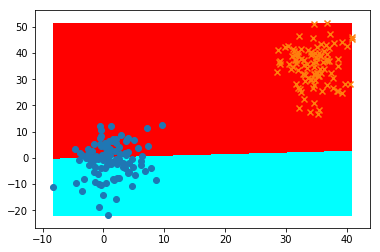

In [16]:
classifieur_random=ClassifierRandom(2)

the_set=dataSet_100
plot_frontiere(the_set,classifieur_random)
plot2DSet(the_set)

### Étape 3 : k-NN

L'objectif est de définir le classifieur k-NN. Pour cela nous allons construire un tableau de distances que nous trierons grâce à la méthode `numpy.argsort`.

In [17]:
class KNN(Classifier):
   
    def __init__(self, input_dimension , k ):
        self.k = k 
        self.input_dimension = input_dimension
        
    #Permet de calculer la prediction sur x => renvoie un score
    def predict(self, x):
        distances =[]
        for i in range (self.model.size()):
            #Distance Euclédienne fait par moi même
            # np.sqrt(( self.model.getX(i)[0] -  x[0] )**2  +  ( self.model.getX(i)[1] - x[1] )**2 )
            #Pour des Dimensions énormes faut penser a utiliser une fonction  prédéfinie Ex : np.linalg.norm
            distances.append( np.linalg.norm(self.model.getX(i)-x) ) 
        #Sort distances
        distances = np.argsort(np.array(distances)) 
        S = 0 
        for i in range(self.k):
            #Pas la peine de faire la moyenne
            S = S + self.model.getY(distances[i])
        if ( S < 0 ) : return -1
        return +1
    
        
    #Permet d'entrainer le modèle sur un ensemble de données
    def train(self, labeledSet):
        self.model = labeledSet
        
            
    
            

/home/raouf/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


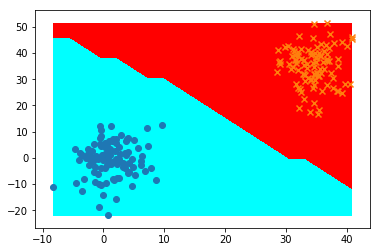

In [18]:
knn=KNN(2 , 15 )
knn.train(the_set)
plot_frontiere(the_set,knn,20)
plot2DSet(the_set) 

In [19]:
#SUr une nouvelle donnée
knn.predict([10,10])

1

In [20]:
#sur une donnée du model
knn.predict(the_set.getX(180))

-1

### Étape 4: protocole expérimental

Attention, lorsque vous testez un classifieur, il est nécessaire de considérer à la fois un ensemble d'apprentissage et un ensemble de test. La performance doit être évaluée sur l'ensemble de test (et non pas sur l'ensemble d'apprentissage).

In [21]:
#Prepare
new_set = generate_Dataset(0,30,50)
new_knn = KNN(2,10)
#train on 80 values  ( 40 positive and 40 negative )
trainSet = LabeledSet(2)
vec = np.vstack( (new_set.x[:40] , new_set.x[50:90]) ) 
lab = np.vstack( (new_set.y[:40] , new_set.y[50:90]) ) 
n = int(vec.size / 2)
for i in range(n) :
    trainSet.addExample(vec[i],lab[i])
new_knn.train ( trainSet )
#test on 20 values  ( 10 positive and 10 negative )
testSet = LabeledSet(2)
vec = np.vstack( (new_set.x[40:50] , new_set.x[90:]) )
lab = np.vstack( (new_set.y[40:50] , new_set.y[90:]) )
n = int(vec.size / 2)
for i in range(n) :
    testSet.addExample(vec[i],lab[i])
print ("The accuracy is : ", new_knn.accuracy(testSet) )
# l'accuracy est 100%  car l'ensemble est petit et les points entre les 2 groupes
# sont très loins donc il se trompera jamais
#Faut Varier le generateData  les 2 moyennes  pour voir  des résultats Différents

The accuracy is :  100.0


#### Travail libre

Comparer la performance (en train et test) de plusieurs classifieurs KNN avec différentes valeurs de k. Que pouvez vous constater ?
Idéalement, vous tracerez la performance (accuracy) en fonction de la valeur de k.
Essayez avec différentes configurations de gaussiennes.

In [22]:
def Train_Test_Split(dataset, training_percent):
    #Pré-conditions
    if (training_percent > 1 ) :
        training_percent = 1 
    elif (training_percent < 0 ) : 
        training_percent = 0
    
    #Constantes
    size = dataset.size()
    end_class1_Train = int(size*training_percent/2)
    end_class2_Train = int(size/2 + size*training_percent/2 )
    
    #Préparer  les données d'apprentissage d'une manière équitable entre les deux classes 
    trainSet = LabeledSet(2)
    vec = np.vstack( (dataset.x[:end_class1_Train] , dataset.x[int(size/2):end_class2_Train]) ) 
    lab = np.vstack( (dataset.y[:end_class1_Train] , dataset.y[int(size/2):end_class2_Train]) ) 
    n = len(vec)
    for i in range(n) :
        trainSet.addExample(vec[i],lab[i])

    #Préparer  les données de Test d'une manière équitable entre les deux classes 
    testSet = LabeledSet(2)
    vec = np.vstack( (dataset.x[end_class1_Train:int(size/2)] , dataset.x[end_class2_Train:]) )
    lab = np.vstack( (dataset.y[end_class1_Train:int(size/2)] , dataset.y[end_class2_Train:]) )
    n = len(vec)
    for i in range(n) :
        testSet.addExample(vec[i],lab[i])
        
    return trainSet , testSet

for k =  0  The accuracy is :  50.0
for k =  1  The accuracy is :  76.66666666666667
for k =  2  The accuracy is :  80.0
for k =  3  The accuracy is :  76.66666666666667
for k =  4  The accuracy is :  86.66666666666667
for k =  5  The accuracy is :  93.33333333333333
for k =  6  The accuracy is :  93.33333333333333
for k =  7  The accuracy is :  86.66666666666667
for k =  8  The accuracy is :  93.33333333333333
for k =  9  The accuracy is :  80.0
for k =  10  The accuracy is :  90.0
for k =  11  The accuracy is :  90.0
for k =  12  The accuracy is :  90.0
for k =  13  The accuracy is :  93.33333333333333
for k =  14  The accuracy is :  90.0
for k =  15  The accuracy is :  93.33333333333333
for k =  16  The accuracy is :  93.33333333333333
for k =  17  The accuracy is :  93.33333333333333
for k =  18  The accuracy is :  90.0
for k =  19  The accuracy is :  93.33333333333333
for k =  20  The accuracy is :  93.33333333333333
for k =  21  The accuracy is :  93.33333333333333
for k =  22  T

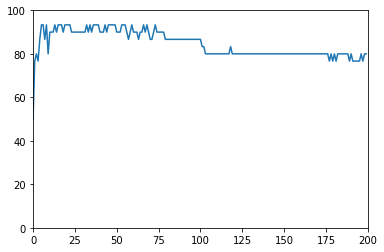

In [24]:
# pour une seule gaussienne
new_set = generate_Dataset(1,5,150)
trainSet , testSet = Train_Test_Split(new_set,0.9)
k_list = list()
accuracy_list = list()


for k in range (200):
    k_list.append(k)
    new_knn = KNN(2,k)
    new_knn.train ( trainSet )
    acc = new_knn.accuracy(testSet)
    accuracy_list.append(acc)
    print ("for k = ",k," The accuracy is : ", acc  )
    
plt.plot( k_list ,accuracy_list )
plt.axis([0, 200, 0, 100])
plt.show()

__ATTENTION__ !

_Préconditions_ : ( K >= TrainSet.size() )  
sinon on aura une exception out of bounds   mais bon ça reste gérable aussi en programmation si
 bound_loop = max ( self.k , model.size() )   pour la boucle

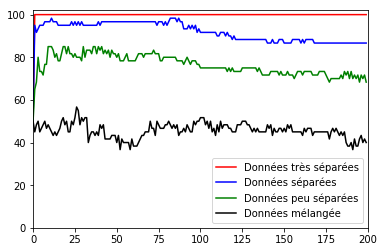

In [25]:
# pour plusieurs configurations gaussiennes

#premiere config des points très loins  moyenne 1 vs 35
k_list1 = list()
accuracy_list1 = list()
new_set = generate_Dataset(1,35,150)
trainSet , testSet = Train_Test_Split(new_set,0.8)

for k in range (200):
    k_list1.append(k)
    new_knn = KNN(2,k)
    new_knn.train ( trainSet )
    acc = new_knn.accuracy(testSet)
    accuracy_list1.append(acc)
    

#deuxieme config
k_list2 = list()
accuracy_list2 = list()
new_set = generate_Dataset(1,10,150)
trainSet , testSet = Train_Test_Split(new_set,0.8)

for k in range (200):
    k_list2.append(k)
    new_knn = KNN(2,k)
    new_knn.train ( trainSet )
    acc = new_knn.accuracy(testSet)
    accuracy_list2.append(acc)
    
#troisieme config
k_list3 = list()
accuracy_list3 = list()
new_set = generate_Dataset(1,5,150)
trainSet , testSet = Train_Test_Split(new_set,0.8)

for k in range (200):
    k_list3.append(k)
    new_knn = KNN(2,k)
    new_knn.train ( trainSet )
    acc = new_knn.accuracy(testSet)
    accuracy_list3.append(acc)
    
#quatrieme config
k_list4 = list()
accuracy_list4 = list()
new_set = generate_Dataset(1,1.5,150)
trainSet , testSet = Train_Test_Split(new_set,0.8)

for k in range (200):
    k_list4.append(k)
    new_knn = KNN(2,k)
    new_knn.train ( trainSet )
    acc = new_knn.accuracy(testSet)
    accuracy_list4.append(acc)
    
plt.plot( k_list1 ,accuracy_list1 ,'r' ,  k_list2 ,accuracy_list2 ,'b' ,
          k_list3 ,accuracy_list3 ,'g' ,  k_list4 ,accuracy_list4 ,'k'  )

plt.legend(['Données très séparées', 'Données séparées',
            'Données peu séparées', 'Données mélangée'], loc='lower right')
plt.axis([0, 200, 0, 102])
plt.show()

### Étape 5 : données réelles UCI

Plusieurs datasets sont téléchargeables depuis: http://mldata.org

Voici la fonction permettant de les charger (en spécifiant leur nom). La fonction se charge de charger les données depuis le web.

In [ ]:
from sklearn.datasets import fetch_mldata

def loadFile(name):
    data = fetch_mldata(name, data_home='.')
    unique=np.unique(data.target)
    for i in range(len(data.target)):
        if (data.target[i]==unique[0]):
            data.target[i]=1
        else:
            data.target[i]=-1
    return data
            
data = loadFile('breast-cancer_scale')
#Les donnees sont dans data.data et data.target

Écrire la fonction de split permettant de découper les données en un ensemble d'apprentissage et un ensemble de test.

* Elle déjà faite son prototype est : 
```
def Train_Test_Split(dataset, training_percent)
```

Tester différents k-NN , pour différents k, et tracer la courbe de performance (accuracy) pour les données d'apprentissage et les données de test.

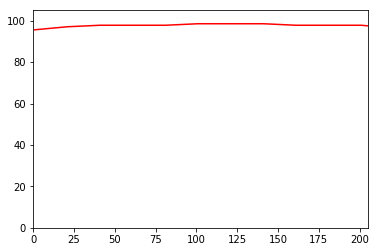

In [32]:
k_listreal = list()
accuracy_listreal = list()
dimension = len ( data.data[0] ) 
#### Préparer notre labeledSet
dataset = LabeledSet (dimension)
for i in range(len(data.data)):
        dataset.addExample(data.data[i],data.target[i])
trainSet , testSet = Train_Test_Split(dataset,0.8)
for k in range (1,500,20):
    k_listreal.append(k)
    new_knn = KNN(dataset.getInputDimension,k)
    new_knn.train ( trainSet )
    acc = new_knn.accuracy(testSet)
    accuracy_listreal.append(acc)
#to clean the entire plot
######################
plt.plot( k_listreal  ,accuracy_listreal ,'r'   )
plt.axis([0, 205, 0, 105])
plt.show()